In [48]:
import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

iris = datasets.load_iris()
X, y = iris.data, iris.target
n_classes = len(np.unique(y))


# init
class GMM(GaussianMixture):
    def __init__(self, *args, **kargs):
        super().__init__(*args, **kargs)
        self.weights = []
        self.means = []
        self.covariances = []


covariance_types = ["full", "tied", "diag", "spherical"]
estimators = {
    cov_type: GMM(n_components=n_classes,
                  covariance_type=cov_type,
                  random_state=0)
    for cov_type in covariance_types
}
# fit & get result
for gmm in estimators.values():
    gmm.fit(X, y)
    for n in range(n_classes):
        # 获取每一类的高斯分布参数
        gmm.means.append(gmm.means_[n])
        gmm.weights.append(gmm.weights_[n])
        # 获得协方差矩阵
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        gmm.covariances.append(covariances)  # 4x4 matrix * 3

# print
for cov_type, gmm in estimators.items():
    print(f"covariance structures 为 {cov_type} 的结果:")
    for n in range(len(gmm.weights)):
        s = f"""第{n+1}个高斯分布:
        权重 {gmm.weights[n]}
        均值 {gmm.means[n]}
        协方差矩阵 {gmm.covariances[n]}"""
        print(s)


covariance structures 为 full 的结果:
第1个高斯分布:
        权重 0.33333333333333326
        均值 [5.006 3.428 1.462 0.246]
        协方差矩阵 [[0.121765 0.097232 0.016028 0.010124]
 [0.097232 0.140817 0.011464 0.009112]
 [0.016028 0.011464 0.029557 0.005948]
 [0.010124 0.009112 0.005948 0.010885]]
第2个高斯分布:
        权重 0.3653957450083165
        均值 [6.54639415 2.94946365 5.48364578 1.98726565]
        协方差矩阵 [[0.38744093 0.09223276 0.30244302 0.06087397]
 [0.09223276 0.11040914 0.08385112 0.05574334]
 [0.30244302 0.08385112 0.32589574 0.07276776]
 [0.06087397 0.05574334 0.07276776 0.08484505]]
第3个高斯分布:
        权重 0.30127092165835023
        均值 [5.9170732  2.77804839 4.20540364 1.29848217]
        协方差矩阵 [[0.2755171  0.09662295 0.18547072 0.05478901]
 [0.09662295 0.09255152 0.09103431 0.04299899]
 [0.18547072 0.09103431 0.20235849 0.06171383]
 [0.05478901 0.04299899 0.06171383 0.03233775]]
covariance structures 为 tied 的结果:
第1个高斯分布:
        权重 0.3333333333356403
        均值 [5.006 3.428 1.462 0.246]
        协

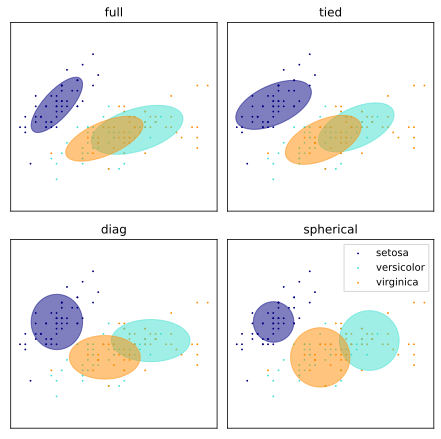

In [49]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
# plot
# 高斯分布有4个维度, 这里取前两个维度进行展示
def make_ellipses(gmm, ax):
    """根据高斯分布的协方差矩阵画出椭圆"""
    for n, color in enumerate(colors):
        covariances = gmm.covariances[n][:2, :2]  # (取前两个维度)
        v, w = np.linalg.eigh(covariances)  # 协方差矩阵的特征值 w 特征向量 v
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2],
                                  v[0],
                                  v[1],
                                  180 + angle,
                                  color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")

colors = ["navy", "turquoise", "darkorange"]
n_estimators = len(estimators)
plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=0.01,
                    top=0.95,
                    hspace=0.15,
                    wspace=0.05,
                    left=0.01,
                    right=0.99)
for index, (name, estimator) in enumerate(estimators.items()):
    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(
            data[:, 0], data[:, 1], s=0.8, color=color, label=iris.target_names[n]
        )

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(fancybox=False)
plt.show()
